# 性能对比：SO-101 5-DOF IK 求解器硬件加速 vs 纯软件

本笔记本对比硬件加速（FPGA）和纯 Python 实现的 LM 逆解求解器的性能。

## 1. 导入库和初始化

In [ ]:
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Set plot style
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.facecolor'] = 'white'

# Module path
ik_dir = os.path.join(os.getcwd(), 'ik') if os.path.isdir('ik') else os.getcwd()
if ik_dir not in sys.path:
    sys.path.insert(0, ik_dir)

from robot import create_so101_5dof
from hw_solver_wrapper import create_hw_solver

# Initialize robot
robot = create_so101_5dof()
print(f"✓ Robot created: SO-101 5-DOF")

# Initialize hardware solver
hw_solver = create_hw_solver(robot, bitstream_path='design_1.bit')

if hw_solver and hw_solver.hw_available:
    print("✓ Hardware solver initialized")
    HW_AVAILABLE = True
else:
    print("⚠ Hardware solver not available (using software fallback or disabled)")
    HW_AVAILABLE = False

# Python solver uses robot.ikine_LM() method
print("✓ Python solver (robot.ikine_LM) available")
print("✓ Libraries imported and initialized")

✓ Robot created: SO-101 5-DOF
✓ 硬件求解器已初始化 (基址: 0x40000000, 核名: xf_solver_lm_so101_0)
✓ Hardware solver initialized
✓ Python solver (robot.ikine_LM) available
✓ Libraries imported and initialized


## 2. 硬件加速求解器（FPGA）

## 3. 纯 Python LM 求解器

## 4. 设置测试场景

In [11]:
# Define target pose generation function
def build_target_pose(x=0.3, y=-0.2, z=0.2, roll=0.0, pitch=0.0, yaw=0.0):
    """Build target pose matrix"""
    r = R.from_euler('xyz', [roll, pitch, yaw], degrees=False)
    T = np.eye(4)
    T[:3, :3] = r.as_matrix()
    T[:3, 3] = [x, y, z]
    return T

# Generate diverse test cases
test_cases = [
    # Basic position tests
    {
        'name': 'T1: Front Center',
        'target': build_target_pose(x=0.30, y=0.0, z=0.20),
        'q0': np.zeros(5, dtype=np.float32),
    },
    {
        'name': 'T2: Front Right',
        'target': build_target_pose(x=0.28, y=-0.15, z=0.22),
        'q0': np.array([0.3, 0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    },
    {
        'name': 'T3: Front Left',
        'target': build_target_pose(x=0.28, y=0.15, z=0.22),
        'q0': np.array([-0.3, 0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    },
    # Height variation tests
    {
        'name': 'T4: High Position',
        'target': build_target_pose(x=0.25, y=0.0, z=0.35),
        'q0': np.array([0.0, -0.5, 0.3, 0.0, 0.0], dtype=np.float32),
    },
    {
        'name': 'T5: Low Position',
        'target': build_target_pose(x=0.32, y=0.0, z=0.10),
        'q0': np.array([0.0, 0.5, -0.3, 0.0, 0.0], dtype=np.float32),
    },
    # Orientation tests
    {
        'name': 'T6: With Roll',
        'target': build_target_pose(x=0.28, y=0.0, z=0.22, roll=np.pi/6),
        'q0': np.array([0.0, 0.0, 0.0, 0.0, 0.5], dtype=np.float32),
    },
    {
        'name': 'T7: With Pitch',
        'target': build_target_pose(x=0.28, y=0.0, z=0.22, pitch=-np.pi/6),
        'q0': np.array([0.0, 0.2, -0.1, -0.3, 0.0], dtype=np.float32),
    },
    # Extended reach test
    {
        'name': 'T8: Far Reach',
        'target': build_target_pose(x=0.38, y=0.05, z=0.18),
        'q0': np.array([0.1, -0.3, 0.2, 0.1, 0.0], dtype=np.float32),
    },
    # Convergence tests (initial guess far from solution)
    {
        'name': 'T9: Large Init Offset',
        'target': build_target_pose(x=0.30, y=0.0, z=0.20),
        'q0': np.array([0.8, -0.6, 0.5, -0.4, 0.3], dtype=np.float32),
    },
    {
        'name': 'T10: Combined Pose',
        'target': build_target_pose(x=0.26, y=0.08, z=0.25, roll=np.pi/8, pitch=-np.pi/8),
        'q0': np.array([-0.2, 0.1, 0.2, -0.1, 0.2], dtype=np.float32),
    },
]

# Error weight mask (position + orientation)
mask = np.array([1, 1, 1, 0.8, 0.8, 0], dtype=np.float32)

print(f"✓ Defined {len(test_cases)} test cases")
print(f"  Error mask: {mask}")
print("\nTest case list:")
for i, tc in enumerate(test_cases):
    pos = tc['target'][:3, 3]
    print(f"  [{i+1}] {tc['name']}: pos=[{pos[0]:.3f}, {pos[1]:.3f}, {pos[2]:.3f}]")

✓ Defined 10 test cases
  Error mask: [1.  1.  1.  0.8 0.8 0. ]

Test case list:
  [1] T1: Front Center: pos=[0.300, 0.000, 0.200]
  [2] T2: Front Right: pos=[0.280, -0.150, 0.220]
  [3] T3: Front Left: pos=[0.280, 0.150, 0.220]
  [4] T4: High Position: pos=[0.250, 0.000, 0.350]
  [5] T5: Low Position: pos=[0.320, 0.000, 0.100]
  [6] T6: With Roll: pos=[0.280, 0.000, 0.220]
  [7] T7: With Pitch: pos=[0.280, 0.000, 0.220]
  [8] T8: Far Reach: pos=[0.380, 0.050, 0.180]
  [9] T9: Large Init Offset: pos=[0.300, 0.000, 0.200]
  [10] T10: Combined Pose: pos=[0.260, 0.080, 0.250]


## 5. 执行性能对比测试

In [12]:
# 执行对比测试
results = []

# 求解器参数
IK_PARAMS = {
    'ilimit': 500,
    'slimit': 10,
    'tol': 1e-7,
    'k': 0.1,
    'method': 'wampler'
}

print("="*80)
print(f"{'开始性能对比测试':^80}")
print("="*80)
print(f"参数: ilimit={IK_PARAMS['ilimit']}, tol={IK_PARAMS['tol']}, k={IK_PARAMS['k']}, method={IK_PARAMS['method']}")
print("="*80)

for i, test_case in enumerate(test_cases):
    print(f"\n[{i+1}/{len(test_cases)}] {test_case['name']}")
    print("-"*60)
    
    T_goal = test_case['target']
    q0 = test_case['q0']
    
    # 纯 Python 求解
    py_start = time.perf_counter()
    py_result = robot.ikine_LM(
        Tep=T_goal,
        q0=q0,
        ilimit=IK_PARAMS['ilimit'],
        slimit=IK_PARAMS['slimit'],
        tol=IK_PARAMS['tol'],
        mask=mask,
        k=IK_PARAMS['k'],
        method=IK_PARAMS['method']
    )
    py_time = time.perf_counter() - py_start
    
    print(f"  Python: {'✓' if py_result.success else '✗'} | "
          f"iters={py_result.iterations:4d} | "
          f"error={py_result.final_error:.2e} | "
          f"time={py_time:.4f}s")
    
    # 硬件求解（如果可用）
    hw_result = None
    hw_time = 0
    if HW_AVAILABLE:
        hw_start = time.perf_counter()
        hw_result = hw_solver.solve(
            T_goal,
            q0=q0,
            ilimit=IK_PARAMS['ilimit'],
            slimit=IK_PARAMS['slimit'],
            tol=IK_PARAMS['tol'],
            mask=mask,
            k=IK_PARAMS['k'],
            verbose=False
        )
        hw_time = time.perf_counter() - hw_start
        
        speedup = py_time / hw_time if hw_time > 0 else 0
        print(f"  HW:     {'✓' if hw_result.success else '✗'} | "
              f"iters={hw_result.iterations:4d} | "
              f"error={hw_result.final_error:.2e} | "
              f"time={hw_time:.4f}s | "
              f"加速={speedup:.1f}x")
    
    # 记录结果
    results.append({
        'name': test_case['name'],
        'q0': q0,
        'T_goal': T_goal,
        'py_result': py_result,
        'py_time': py_time,
        'hw_result': hw_result,
        'hw_time': hw_time,
    })

print("\n" + "="*80)
print(f"{'测试完成':^80}")
print("="*80)

                                    开始性能对比测试                                    
参数: ilimit=500, tol=1e-07, k=0.1, method=wampler

[1/10] T1: Front Center
------------------------------------------------------------
  Python: ✓ | iters=  80 | error=9.19e-08 | time=1.1101s
  HW:     ✓ | iters=  79 | error=9.19e-08 | time=0.4018s | 加速=2.8x

[2/10] T2: Front Right
------------------------------------------------------------
  Python: ✓ | iters=  63 | error=9.21e-08 | time=0.8620s
  HW:     ✓ | iters= 109 | error=9.20e-08 | time=0.5744s | 加速=1.5x

[3/10] T3: Front Left
------------------------------------------------------------
  Python: ✓ | iters=  63 | error=9.21e-08 | time=0.8541s
  HW:     ✓ | iters= 109 | error=9.20e-08 | time=0.5486s | 加速=1.6x

[4/10] T4: High Position
------------------------------------------------------------
  Python: ✓ | iters= 186 | error=9.65e-08 | time=2.5057s
  HW:     ✓ | iters= 185 | error=9.68e-08 | time=0.9271s | 加速=2.7x

[5/10] T5: Low Position
-------

## 6. 性能对比分析

In [13]:
import pandas as pd

# 生成对比表格
comparison_data = []

for result in results:
    py_res = result['py_result']
    
    row = {
        'Test': result['name'],
        'Py Time(s)': result['py_time'],
        'Py Iters': py_res.iterations,
        'Py Error': py_res.final_error,
        'Py OK': py_res.success,
    }
    
    hw_res = result['hw_result']
    if hw_res is not None:
        speedup = result['py_time'] / result['hw_time'] if result['hw_time'] > 0 else 0
        row.update({
            'HW Time(s)': result['hw_time'],
            'HW Iters': hw_res.iterations,
            'HW Error': hw_res.final_error,
            'HW OK': hw_res.success,
            'Speedup': speedup,
        })
    
    comparison_data.append(row)

df = pd.DataFrame(comparison_data)

# 计算统计信息
print("\n" + "="*100)
print(f"{'性能对比总结':^100}")
print("="*100)

# 格式化显示
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df.to_string(index=False, float_format='%.4f'))

# 统计摘要
print("\n" + "-"*100)
print("统计摘要:")
print("-"*100)
py_success = sum(1 for r in results if r['py_result'].success)
py_avg_time = np.mean([r['py_time'] for r in results])
py_avg_iters = np.mean([r['py_result'].iterations for r in results])

print(f"  Python 成功率: {py_success}/{len(results)} ({100*py_success/len(results):.1f}%)")
print(f"  Python 平均耗时: {py_avg_time:.4f} s")
print(f"  Python 平均迭代: {py_avg_iters:.1f}")

if HW_AVAILABLE:
    hw_success = sum(1 for r in results if r['hw_result'] and r['hw_result'].success)
    hw_avg_time = np.mean([r['hw_time'] for r in results])
    hw_avg_iters = np.mean([r['hw_result'].iterations for r in results if r['hw_result']])
    avg_speedup = py_avg_time / hw_avg_time if hw_avg_time > 0 else 0
    
    print(f"\n  Hardware 成功率: {hw_success}/{len(results)} ({100*hw_success/len(results):.1f}%)")
    print(f"  Hardware 平均耗时: {hw_avg_time:.4f} s")
    print(f"  Hardware 平均迭代: {hw_avg_iters:.1f}")
    print(f"\n  ⚡ 平均加速比: {avg_speedup:.2f}x")

print("="*100)


                                               性能对比总结                                               
                 Test  Py Time(s)  Py Iters  Py Error  Py OK  HW Time(s)  HW Iters  HW Error  HW OK  Speedup
     T1: Front Center      1.1101        80    0.0000   True      0.4018        79    0.0000   True   2.7630
      T2: Front Right      0.8620        63    0.0000   True      0.5744       109    0.0000   True   1.5006
       T3: Front Left      0.8541        63    0.0000   True      0.5486       109    0.0000   True   1.5569
    T4: High Position      2.5057       186    0.0000   True      0.9271       185    0.0000   True   2.7026
     T5: Low Position      1.2437        91    0.0000   True      0.4596        90    0.0000   True   2.7059
        T6: With Roll      1.1158        81    0.0000   True      0.4177        80    0.0000   True   2.6714
       T7: With Pitch      1.2020        87    0.0000   True      0.4304        85    0.0000   True   2.7924
        T8: Far Reach     

## 7. 图表分析

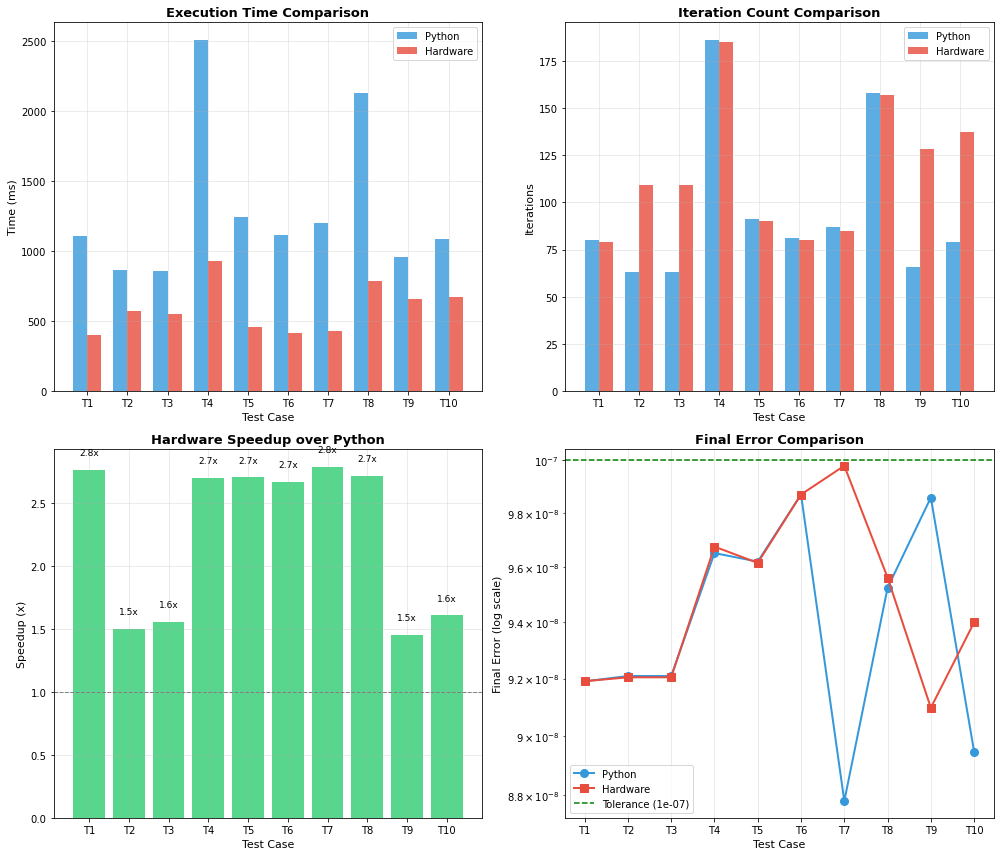


✓ 图表已保存为 ik_solver_comparison.png


In [14]:
# 图表1: 执行时间对比柱状图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 提取数据
test_names = [r['name'].replace(':', '\n') for r in results]
py_times = [r['py_time'] * 1000 for r in results]  # 转为毫秒
py_iters = [r['py_result'].iterations for r in results]
py_errors = [r['py_result'].final_error for r in results]

if HW_AVAILABLE:
    hw_times = [r['hw_time'] * 1000 for r in results]
    hw_iters = [r['hw_result'].iterations for r in results if r['hw_result']]
    hw_errors = [r['hw_result'].final_error for r in results if r['hw_result']]
    speedups = [r['py_time']/r['hw_time'] if r['hw_time'] > 0 else 0 for r in results]

# 图1: 执行时间对比
ax1 = axes[0, 0]
x = np.arange(len(test_names))
width = 0.35
bars1 = ax1.bar(x - width/2, py_times, width, label='Python', color='#3498db', alpha=0.8)
if HW_AVAILABLE:
    bars2 = ax1.bar(x + width/2, hw_times, width, label='Hardware', color='#e74c3c', alpha=0.8)
ax1.set_xlabel('Test Case', fontsize=11)
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('Execution Time Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'T{i+1}' for i in range(len(test_names))], fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 图2: 迭代次数对比
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, py_iters, width, label='Python', color='#3498db', alpha=0.8)
if HW_AVAILABLE:
    bars4 = ax2.bar(x + width/2, hw_iters, width, label='Hardware', color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Test Case', fontsize=11)
ax2.set_ylabel('Iterations', fontsize=11)
ax2.set_title('Iteration Count Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'T{i+1}' for i in range(len(test_names))], fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 图3: 加速比 (如果硬件可用)
ax3 = axes[1, 0]
if HW_AVAILABLE:
    colors = ['#2ecc71' if s >= 1 else '#e74c3c' for s in speedups]
    bars5 = ax3.bar(x, speedups, color=colors, alpha=0.8)
    ax3.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Baseline (1x)')
    ax3.set_xlabel('Test Case', fontsize=11)
    ax3.set_ylabel('Speedup (x)', fontsize=11)
    ax3.set_title('Hardware Speedup over Python', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'T{i+1}' for i in range(len(test_names))], fontsize=10)
    # 添加数值标签
    for bar, val in zip(bars5, speedups):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{val:.1f}x', ha='center', va='bottom', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'Hardware Not Available', ha='center', va='center', 
             fontsize=14, transform=ax3.transAxes)
    ax3.set_title('Hardware Speedup', fontsize=13, fontweight='bold')

# 图4: 最终误差对比 (对数刻度)
ax4 = axes[1, 1]
ax4.semilogy(x, py_errors, 'o-', label='Python', color='#3498db', markersize=8, linewidth=2)
if HW_AVAILABLE:
    ax4.semilogy(x, hw_errors, 's-', label='Hardware', color='#e74c3c', markersize=8, linewidth=2)
ax4.axhline(y=IK_PARAMS['tol'], color='green', linestyle='--', linewidth=1.5, label=f"Tolerance ({IK_PARAMS['tol']})")
ax4.set_xlabel('Test Case', fontsize=11)
ax4.set_ylabel('Final Error (log scale)', fontsize=11)
ax4.set_title('Final Error Comparison', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f'T{i+1}' for i in range(len(test_names))], fontsize=10)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ik_solver_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ 图表已保存为 ik_solver_comparison.png")

## 8. 详细性能分布分析

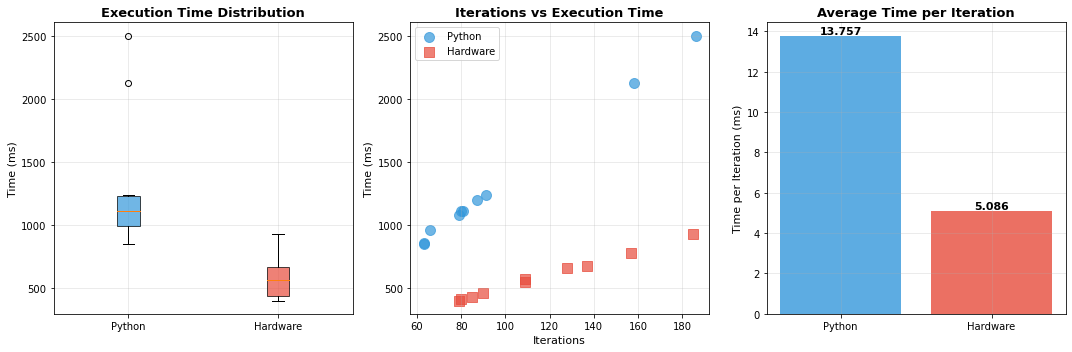


✓ 分布图已保存为 ik_solver_distribution.png


In [15]:
# 详细分布分析图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 图1: 时间分布箱线图
ax1 = axes[0]
box_data = [py_times]
labels = ['Python']
colors = ['#3498db']
if HW_AVAILABLE:
    box_data.append(hw_times)
    labels.append('Hardware')
    colors.append('#e74c3c')

bp = ax1.boxplot(box_data, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('Execution Time Distribution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 图2: 迭代次数 vs 执行时间 散点图
ax2 = axes[1]
ax2.scatter(py_iters, py_times, s=100, c='#3498db', alpha=0.7, label='Python', marker='o')
if HW_AVAILABLE:
    ax2.scatter(hw_iters, hw_times, s=100, c='#e74c3c', alpha=0.7, label='Hardware', marker='s')
ax2.set_xlabel('Iterations', fontsize=11)
ax2.set_ylabel('Time (ms)', fontsize=11)
ax2.set_title('Iterations vs Execution Time', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 图3: 每迭代平均时间
ax3 = axes[2]
py_time_per_iter = [t/i if i > 0 else 0 for t, i in zip(py_times, py_iters)]
bar_data = [np.mean(py_time_per_iter)]
bar_labels = ['Python']
bar_colors = ['#3498db']
if HW_AVAILABLE:
    hw_time_per_iter = [t/i if i > 0 else 0 for t, i in zip(hw_times, hw_iters)]
    bar_data.append(np.mean(hw_time_per_iter))
    bar_labels.append('Hardware')
    bar_colors.append('#e74c3c')

bars = ax3.bar(bar_labels, bar_data, color=bar_colors, alpha=0.8)
ax3.set_ylabel('Time per Iteration (ms)', fontsize=11)
ax3.set_title('Average Time per Iteration', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# 添加数值标签
for bar, val in zip(bars, bar_data):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('ik_solver_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ 分布图已保存为 ik_solver_distribution.png")

## 9. 重复测试统计 (可靠性分析)

运行 5 次重复测试...
  第 1/5 轮... ✓
  第 2/5 轮... ✓
  第 3/5 轮... ✓
  第 4/5 轮... ✓
  第 5/5 轮... ✓


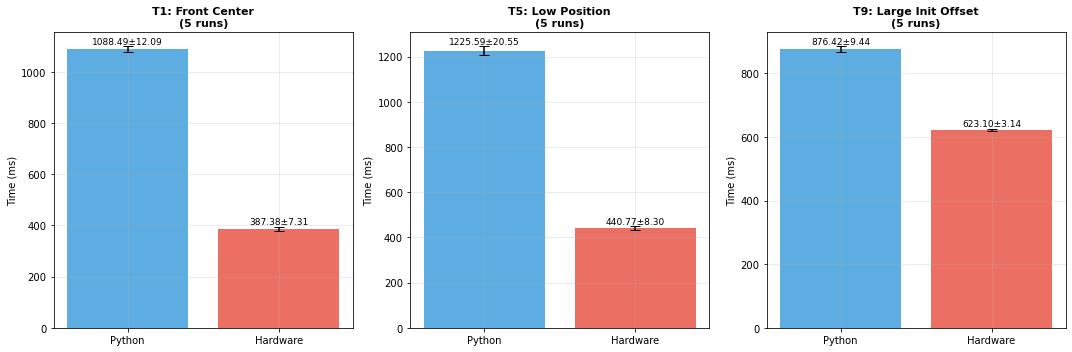


重复测试统计结果:
--------------------------------------------------------------------------------

T1: Front Center:
  Python: 1088.49 ± 12.09 ms
  Hardware: 387.38 ± 7.31 ms
  Speedup: 2.81x

T5: Low Position:
  Python: 1225.59 ± 20.55 ms
  Hardware: 440.77 ± 8.30 ms
  Speedup: 2.78x

T9: Large Init Offset:
  Python: 876.42 ± 9.44 ms
  Hardware: 623.10 ± 3.14 ms
  Speedup: 1.41x

✓ 重复测试图已保存为 ik_repeat_test.png


In [7]:
# 重复测试以获取稳定的统计数据
NUM_REPEATS = 5

print(f"运行 {NUM_REPEATS} 次重复测试...")
print("="*80)

# 选取代表性测试用例
repeat_test_cases = [test_cases[0], test_cases[4], test_cases[8]]  # T1, T5, T9

repeat_results = {tc['name']: {'py_times': [], 'hw_times': []} for tc in repeat_test_cases}

for rep in range(NUM_REPEATS):
    print(f"  第 {rep+1}/{NUM_REPEATS} 轮...", end=" ")
    for tc in repeat_test_cases:
        T_goal = tc['target']
        q0 = tc['q0']
        
        # Python
        py_start = time.perf_counter()
        py_result = robot.ikine_LM(Tep=T_goal, q0=q0, **IK_PARAMS, mask=mask)
        py_time = (time.perf_counter() - py_start) * 1000
        repeat_results[tc['name']]['py_times'].append(py_time)
        
        # Hardware
        if HW_AVAILABLE:
            hw_start = time.perf_counter()
            hw_result = hw_solver.solve(T_goal, q0=q0, **IK_PARAMS, mask=mask, verbose=False)
            hw_time = (time.perf_counter() - hw_start) * 1000
            repeat_results[tc['name']]['hw_times'].append(hw_time)
    
    print("✓")

print("="*80)

# 绘制重复测试结果
fig, axes = plt.subplots(1, len(repeat_test_cases), figsize=(5*len(repeat_test_cases), 5))

for i, tc in enumerate(repeat_test_cases):
    ax = axes[i] if len(repeat_test_cases) > 1 else axes
    name = tc['name']
    py_t = repeat_results[name]['py_times']
    
    # 绘制条形图
    x_pos = [0, 1] if HW_AVAILABLE else [0]
    means = [np.mean(py_t)]
    stds = [np.std(py_t)]
    labels = ['Python']
    colors = ['#3498db']
    
    if HW_AVAILABLE:
        hw_t = repeat_results[name]['hw_times']
        means.append(np.mean(hw_t))
        stds.append(np.std(hw_t))
        labels.append('Hardware')
        colors.append('#e74c3c')
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Time (ms)')
    ax.set_title(f'{name}\n({NUM_REPEATS} runs)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 添加数值
    for bar, m, s in zip(bars, means, stds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.5,
                f'{m:.2f}±{s:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('ik_repeat_test.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印统计结果
print("\n重复测试统计结果:")
print("-"*80)
for tc in repeat_test_cases:
    name = tc['name']
    py_t = repeat_results[name]['py_times']
    print(f"\n{name}:")
    print(f"  Python: {np.mean(py_t):.2f} ± {np.std(py_t):.2f} ms")
    if HW_AVAILABLE:
        hw_t = repeat_results[name]['hw_times']
        speedup = np.mean(py_t) / np.mean(hw_t)
        print(f"  Hardware: {np.mean(hw_t):.2f} ± {np.std(hw_t):.2f} ms")
        print(f"  Speedup: {speedup:.2f}x")

print("\n✓ 重复测试图已保存为 ik_repeat_test.png")

## 10. 关节轨迹验证

In [8]:
# 验证求解结果的正运动学误差
print("关节角度和末端位姿验证:")
print("="*100)

joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll']

for i, result in enumerate(results[:5]):  # 验证前5个测试用例
    print(f"\n[{result['name']}]")
    print("-"*80)
    
    T_goal = result['T_goal']
    goal_pos = T_goal[:3, 3]
    
    # Python 解
    py_q = result['py_result'].q
    T_py = robot.fkine(py_q)
    py_pos = T_py[:3, 3]
    py_pos_error = np.linalg.norm(goal_pos - py_pos) * 1000  # mm
    
    print(f"  目标位置: [{goal_pos[0]:.4f}, {goal_pos[1]:.4f}, {goal_pos[2]:.4f}]")
    print(f"  Python解: [{py_pos[0]:.4f}, {py_pos[1]:.4f}, {py_pos[2]:.4f}]  位置误差: {py_pos_error:.3f} mm")
    print(f"  关节角 (deg): {np.degrees(py_q)}")
    
    # Hardware 解 (如果可用)
    if HW_AVAILABLE and result['hw_result']:
        hw_q = result['hw_result'].q
        T_hw = robot.fkine(hw_q)
        hw_pos = T_hw[:3, 3]
        hw_pos_error = np.linalg.norm(goal_pos - hw_pos) * 1000
        q_diff = np.linalg.norm(py_q - hw_q)
        
        print(f"  HW解:     [{hw_pos[0]:.4f}, {hw_pos[1]:.4f}, {hw_pos[2]:.4f}]  位置误差: {hw_pos_error:.3f} mm")
        print(f"  关节角差异 (rad): {q_diff:.6f}")

print("\n" + "="*100)

关节角度和末端位姿验证:

[T1: Front Center]
--------------------------------------------------------------------------------
  目标位置: [0.3000, 0.0000, 0.2000]
  Python解: [0.3004, 0.0000, 0.2001]  位置误差: 0.402 mm
  关节角 (deg): [  0.       -13.545015  30.723377 -17.177979   0.      ]
  HW解:     [0.3004, 0.0000, 0.2001]  位置误差: 0.429 mm
  关节角差异 (rad): 0.000326

[T2: Front Right]
--------------------------------------------------------------------------------
  目标位置: [0.2800, -0.1500, 0.2200]
  Python解: [0.2803, -0.1502, 0.2202]  位置误差: 0.408 mm
  关节角 (deg): [-3.4432880e+01 -2.5672221e+00  1.1326871e+01 -8.7587471e+00
  3.0052831e-04]
  HW解:     [0.2800, -0.1496, 0.2199]  位置误差: 0.429 mm
  关节角差异 (rad): 0.009176

[T3: Front Left]
--------------------------------------------------------------------------------
  目标位置: [0.2800, 0.1500, 0.2200]
  Python解: [0.2803, 0.1502, 0.2202]  位置误差: 0.408 mm
  关节角 (deg): [ 3.4432880e+01 -2.5672221e+00  1.1326871e+01 -8.7587471e+00
 -3.0052831e-04]
  HW解:     [0.2800, 0.149

## 11. 性能总结与结论

In [16]:
# 生成最终总结报告
print("╔" + "═"*78 + "╗")
print("║" + " "*25 + "SO-101 IK 求解器性能评估报告" + " "*25 + "║")
print("╠" + "═"*78 + "╣")

# 测试概要
print(f"║ 测试用例数量: {len(results):<62} ║")
print(f"║ 求解器参数: ilimit={IK_PARAMS['ilimit']}, tol={IK_PARAMS['tol']}, k={IK_PARAMS['k']}, method={IK_PARAMS['method']:<16} ║")
print("╠" + "═"*78 + "╣")

# Python 性能
py_success_rate = 100 * sum(1 for r in results if r['py_result'].success) / len(results)
py_avg_time = np.mean([r['py_time'] for r in results]) * 1000
py_avg_iters = np.mean([r['py_result'].iterations for r in results])

print(f"║ {'Python 求解器':<76} ║")
print(f"║   成功率: {py_success_rate:.1f}%{' '*66} ║")
print(f"║   平均耗时: {py_avg_time:.2f} ms{' '*60} ║")
print(f"║   平均迭代: {py_avg_iters:.1f}{' '*63} ║")

# Hardware 性能
if HW_AVAILABLE:
    hw_success_rate = 100 * sum(1 for r in results if r['hw_result'] and r['hw_result'].success) / len(results)
    hw_avg_time = np.mean([r['hw_time'] for r in results]) * 1000
    hw_avg_iters = np.mean([r['hw_result'].iterations for r in results if r['hw_result']])
    avg_speedup = py_avg_time / hw_avg_time
    
    print("╠" + "═"*78 + "╣")
    print(f"║ {'硬件加速求解器 (FPGA)':<76} ║")
    print(f"║   成功率: {hw_success_rate:.1f}%{' '*66} ║")
    print(f"║   平均耗时: {hw_avg_time:.2f} ms{' '*60} ║")
    print(f"║   平均迭代: {hw_avg_iters:.1f}{' '*63} ║")
    print("╠" + "═"*78 + "╣")
    print(f"║ {'⚡ 性能提升':<76} ║")
    print(f"║   平均加速比: {avg_speedup:.2f}x{' '*60} ║")
    
    # 最佳/最差加速
    speedups = [r['py_time']/r['hw_time'] for r in results if r['hw_time'] > 0]
    print(f"║   最大加速比: {max(speedups):.2f}x{' '*60} ║")
    print(f"║   最小加速比: {min(speedups):.2f}x{' '*60} ║")
else:
    print("╠" + "═"*78 + "╣")
    print(f"║ {'⚠ 硬件不可用':<76} ║")

print("╠" + "═"*78 + "╣")
print(f"║ {'结论':<76} ║")

if HW_AVAILABLE and avg_speedup > 1:
    conclusion = f"✓ 硬件加速器相比纯Python实现平均提速 {avg_speedup:.1f} 倍"
else:
    conclusion = "仅测试了Python求解器性能"
print(f"║   {conclusion:<74} ║")

print("╚" + "═"*78 + "╝")

# 保存所有图表的说明
print("\n生成的图表文件:")
print("  1. ik_solver_comparison.png - 性能对比总览")
print("  2. ik_solver_distribution.png - 性能分布分析")
print("  3. ik_repeat_test.png - 重复测试统计")

╔══════════════════════════════════════════════════════════════════════════════╗
║                         SO-101 IK 求解器性能评估报告                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ 测试用例数量: 10                                                             ║
║ 求解器参数: ilimit=500, tol=1e-07, k=0.1, method=wampler          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Python 求解器                                                                   ║
║   成功率: 100.0%                                                                   ║
║   平均耗时: 1306.51 ms                                                             ║
║   平均迭代: 95.4                                                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ 硬件加速求解器 (FPGA)                                                               ║
║   成功率: 100.0%                                        